In [27]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from PIL import Image
import requests
import random
from sklearn.metrics.pairwise import cosine_similarity
import io
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

In [28]:
books = pd.read_csv('/content/drive/MyDrive/2023-2/KHUDA/Books.csv')
ratings = pd.read_csv('/content/drive/MyDrive/2023-2/KHUDA/Ratings.csv')
users = pd.read_csv('/content/drive/MyDrive/2023-2/KHUDA/Users.csv')

# 데이터 EDA & 전처리

In [29]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [30]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [31]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [32]:
# 후에 나올 user_book_score() 함수의 구현을 위해 book_value 라는 새로운 데이터 프레임 만들기
book_value = books.drop_duplicates(['Book-Title']) # books 데이터프레임에서 유니크한 책 제목만 남기기
book_value['Book-ID'] = book_value.index # Book-ID 라는 새로운 열을 만들고 유니크한 책마다 0~271359번호를 순서대로 매기기
book_value.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Book-ID
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,1
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,2
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,3
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,4


In [33]:
# book_value의 데이터프레임에서 사용할 열만 추출
book_value = book_value.loc[:,['Book-Title', 'Book-ID']]
book_value

,Book-Title,Book-ID
0,Classical Mythology,0
1,Clara Callan,1
2,Decision in Normandy,2
3,Flu: The Story of the Great Influenza Pandemic...,3
4,The Mummies of Urumchi,4
...,...,...
271354,Flashpoints: Promise and Peril in a New World,271354
271356,From One to One Hundred,271356
271357,Lily Dale : The True Story of the Town that Ta...,271357
271358,Republic (World's Classics),271358


In [34]:
# books를 기준으로 ratings 데이터프레임을 교집합을 통해 조인(key값: ISBN)
books_data = books.merge(ratings, how='left', on='ISBN')
books_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400.0,0.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676.0,8.0
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385.0,0.0


In [35]:
# books를 기준으로 ratings 데이터프레임을 교집합을 통해 조인(key값: ISBN)
df = books.merge(ratings, how='left', on='ISBN')
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400.0,0.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676.0,8.0
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1032340,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,276463.0,7.0
1032341,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,276579.0,4.0
1032342,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,276680.0,0.0
1032343,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,276680.0,0.0


In [36]:
# df를 기준으로 book_value 데이터프레임을 교집합을 통해 조인(key: Book-Title)
df = pd.merge(df, book_value, how='left', on='Book-Title')
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Book-ID
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0,1
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400.0,0.0,1
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676.0,8.0,1
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1032340,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,276463.0,7.0,20738
1032341,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,276579.0,4.0,271356
1032342,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,276680.0,0.0,271357
1032343,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,276680.0,0.0,271358


In [37]:
df.shape

(1032345, 11)

In [38]:
# df 데이터프레임에 존재하는 결측값 확인
df.isnull().sum()

ISBN                      0
Book-Title                0
Book-Author               1
Year-Of-Publication       0
Publisher                 2
Image-URL-S               0
Image-URL-M               0
Image-URL-L               4
User-ID                1209
Book-Rating            1209
Book-ID                   0
dtype: int64

In [39]:
df[df['Book-Rating'].isnull()]

#Usef-ID와 Book-Rating이 동시에 missing value라는걸 알 수 있음
#하지만 user-based CF에서는 User-ID와 Book-Rating 모두 필요함
#결측치 처리 필요

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Book-ID
65244,044990671X,Bronze Mirror,Jeanne Larsen,1992,Ballantine Books,http://images.amazon.com/images/P/044990671X.0...,http://images.amazon.com/images/P/044990671X.0...,http://images.amazon.com/images/P/044990671X.0...,NaN,NaN,1365
65253,0929587081,Men and Brethren,James Gould Cozzens,1989,Elephant Paperbacks,http://images.amazon.com/images/P/0929587081.0...,http://images.amazon.com/images/P/0929587081.0...,http://images.amazon.com/images/P/0929587081.0...,NaN,NaN,1367
65254,155970117X,"My Father, His Son",Reidar Jonsson,1991,Little Brown &amp; Co,http://images.amazon.com/images/P/155970117X.0...,http://images.amazon.com/images/P/155970117X.0...,http://images.amazon.com/images/P/155970117X.0...,NaN,NaN,1368
65255,0688105408,Starlings Laughing: A Memoir of Africa,June Vendall Clark,1991,Harpercollins,http://images.amazon.com/images/P/0688105408.0...,http://images.amazon.com/images/P/0688105408.0...,http://images.amazon.com/images/P/0688105408.0...,NaN,NaN,1369
124362,0671568485,The STAR TREK THE RETURN,William Shatner,1996,Audioworks,http://images.amazon.com/images/P/0671568485.0...,http://images.amazon.com/images/P/0671568485.0...,http://images.amazon.com/images/P/0671568485.0...,NaN,NaN,3122
...,...,...,...,...,...,...,...,...,...,...,...
1032326,1874166633,Introducing Nietzsche (Foundations in Children...,Laurence Gane,1998,Natl Book Network,http://images.amazon.com/images/P/1874166633.0...,http://images.amazon.com/images/P/1874166633.0...,http://images.amazon.com/images/P/1874166633.0...,NaN,NaN,271341
1032327,0130897930,Core Web Programming (2nd Edition),Marty Hall,2001,Prentice Hall PTR,http://images.amazon.com/images/P/0130897930.0...,http://images.amazon.com/images/P/0130897930.0...,http://images.amazon.com/images/P/0130897930.0...,NaN,NaN,271342
1032328,020130998X,The Unified Modeling Language Reference Manual...,James Rumbaugh,1998,Addison-Wesley Professional,http://images.amazon.com/images/P/020130998X.0...,http://images.amazon.com/images/P/020130998X.0...,http://images.amazon.com/images/P/020130998X.0...,NaN,NaN,271343
1032329,2268032019,Petite histoire de la dÃ?Â©sinformation,Vladimir Volkoff,1999,Editions du Rocher,http://images.amazon.com/images/P/2268032019.0...,http://images.amazon.com/images/P/2268032019.0...,http://images.amazon.com/images/P/2268032019.0...,NaN,NaN,271344


In [40]:
#결측치가 포함된 행들 제거
df = df.dropna(subset=['Book-Rating', 'User-ID', 'Book-Author', 'Publisher','Image-URL-L'])

df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
User-ID                0
Book-Rating            0
Book-ID                0
dtype: int64

In [41]:
#평점별 책 개수 파악

df['Book-Rating'].value_counts()

0.0     647291
8.0      91803
10.0     71225
7.0      66401
9.0      60776
5.0      45355
6.0      31687
4.0       7617
3.0       5118
2.0       2375
1.0       1481
Name: Book-Rating, dtype: int64

In [42]:
#별점이 0인건 평점을 남기지 않는 것이니 삭제
df = df[df['Book-Rating'] > 0]
df['Book-Rating'].value_counts()

8.0     91803
10.0    71225
7.0     66401
9.0     60776
5.0     45355
6.0     31687
4.0      7617
3.0      5118
2.0      2375
1.0      1481
Name: Book-Rating, dtype: int64

In [43]:
# 책마다 매겨진 평점 개수 파악
df["Book-Title"].value_counts()

#한개만 있는 책도 있다! 근데 이건 우리가 만들 모델에는 쓸모가 없음

The Lovely Bones: A Novel                 707
Wild Animus                               581
The Da Vinci Code                         494
The Secret Life of Bees                   406
The Nanny Diaries: A Novel                393
                                         ... 
Jedi Quest - Path to Truth (Star Wars)      1
Walter's Purple Heart                       1
Trapped Fear Street 51                      1
Heather Takes the Reins                     1
From One to One Hundred                     1
Name: Book-Title, Length: 135564, dtype: int64

In [44]:
rating_counts = pd.DataFrame(df["Book-Title"].value_counts())

#평점이 100개 이하로 있는 책들은 삭제하자!
rare_books = rating_counts[rating_counts['Book-Title'] < 100].index
common_books = df[~df['Book-Title'].isin(rare_books)]

common_books['Book-Title'].value_counts()

The Lovely Bones: A Novel     707
Wild Animus                   581
The Da Vinci Code             494
The Secret Life of Bees       406
The Nanny Diaries: A Novel    393
                             ... 
Congo                         100
Deception Point               100
Daddy's Little Girl           100
Cause of Death                100
Disclosure                    100
Name: Book-Title, Length: 200, dtype: int64

In [45]:
#유저가 남긴 평점 개수 파악
common_books["User-ID"].value_counts()

#한개만 남긴 사람도 있군.. 이런 사람은 사용될 수 없으니 없애자!

11676.0     225
16795.0      81
95359.0      61
60244.0      46
240567.0     42
           ... 
239067.0      1
239468.0      1
242643.0      1
248677.0      1
169893.0      1
Name: User-ID, Length: 16665, dtype: int64

In [46]:
#책 평점을 10개 이하로 남긴 사람을 드랍하자
common_books = common_books[common_books["User-ID"].map(common_books["User-ID"].value_counts()) >= 10]

common_books["User-ID"].value_counts()

11676.0     225
16795.0      81
95359.0      61
60244.0      46
240567.0     42
           ... 
232106.0     10
104113.0     10
78834.0      10
74286.0      10
208671.0     10
Name: User-ID, Length: 434, dtype: int64

In [47]:
# 행의 개수가 1032345 -> 6852 로 감소
common_books.shape

(6852, 11)

# User-based Collaborative Filtering

In [48]:
# common_books를 train_set과 test_set으로 나누기 (User-ID가 균등하게 분포하도록 설정)
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(common_books, stratify=common_books["User-ID"], random_state=42)

In [49]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5139 entries, 180628 to 27832
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ISBN                 5139 non-null   object 
 1   Book-Title           5139 non-null   object 
 2   Book-Author          5139 non-null   object 
 3   Year-Of-Publication  5139 non-null   object 
 4   Publisher            5139 non-null   object 
 5   Image-URL-S          5139 non-null   object 
 6   Image-URL-M          5139 non-null   object 
 7   Image-URL-L          5139 non-null   object 
 8   User-ID              5139 non-null   float64
 9   Book-Rating          5139 non-null   float64
 10  Book-ID              5139 non-null   int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 481.8+ KB


In [50]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1713 entries, 63553 to 185472
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ISBN                 1713 non-null   object 
 1   Book-Title           1713 non-null   object 
 2   Book-Author          1713 non-null   object 
 3   Year-Of-Publication  1713 non-null   object 
 4   Publisher            1713 non-null   object 
 5   Image-URL-S          1713 non-null   object 
 6   Image-URL-M          1713 non-null   object 
 7   Image-URL-L          1713 non-null   object 
 8   User-ID              1713 non-null   float64
 9   Book-Rating          1713 non-null   float64
 10  Book-ID              1713 non-null   int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 160.6+ KB


In [51]:
# 불필요한 열 제거
train_df = train_set.copy()
train_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
train_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Book-ID
180628,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,66942.0,9.0,5431
148748,074343627X,Dreamcatcher,Stephen King,2001,Pocket,236058.0,10.0,881
533760,039548930X,"The Return of the King (The Lord of the Rings,...",J. R. R. Tolkien,1988,Houghton Mifflin Company,170513.0,10.0,4206
491549,1573226122,Lord of the Flies,William Golding,1997,Riverhead Books,219683.0,7.0,1757
125024,0380002930,Watership Down,Richard Adams,1976,Avon,123544.0,8.0,1572
...,...,...,...,...,...,...,...,...
174212,014028009X,Bridget Jones's Diary,Helen Fielding,1999,Penguin Books,178199.0,10.0,166
99913,0385484518,"Tuesdays with Morrie: An Old Man, a Young Man,...",MITCH ALBOM,1997,Doubleday,105979.0,10.0,2290
40183,0140293248,The Girls' Guide to Hunting and Fishing,Melissa Bank,2000,Penguin Books,11676.0,5.0,707
182754,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,76626.0,7.0,5506


In [52]:
# User-ID기준으로 본인이 평점을 매긴 책의 인덱스 값을 그룹화
df_groupby = common_books.groupby(by='User-ID', as_index=False)

In [53]:
# 그룹화된 값을 이용하여 고객이 내린 평점의 평균 구하기
Mean = df_groupby['Book-Rating'].mean()
Mean

,User-ID,Book-Rating
0,254.0,8.823529
1,638.0,9.555556
2,2766.0,8.000000
3,4017.0,9.266667
4,6242.0,6.647059
...,...,...
429,274004.0,8.076923
430,274301.0,7.909091
431,276050.0,8.000000
432,276165.0,9.500000


In [54]:
#가중평균 이용
# 평가 경향을 구하기 위해 평점 편차('평점-해당 사용자의 평점 평균', adg_rating) 구하기
Rating_avg = pd.merge(train_df, Mean, on='User-ID')
Rating_avg['adg_rating'] = Rating_avg['Book-Rating_x'] - Rating_avg['Book-Rating_y']
Rating_avg

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating_x,Book-ID,Book-Rating_y,adg_rating
0,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,66942.0,9.0,5431,7.520000,1.480000
1,0060987561,I Know This Much Is True,Wally Lamb,1999,Regan Books,66942.0,7.0,3022,7.520000,-0.520000
2,0671021001,She's Come Undone (Oprah's Book Club),Wally Lamb,1998,Pocket,66942.0,8.0,485,7.520000,0.480000
3,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,66942.0,9.0,3839,7.520000,1.480000
4,1573229326,How to Be Good,Nick Hornby,2002,Riverhead Books,66942.0,1.0,2544,7.520000,-6.520000
...,...,...,...,...,...,...,...,...,...,...
5134,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",272573.0,9.0,408,8.083333,0.916667
5135,0345378490,Congo,Michael Crichton,1995,Ballantine Books,272573.0,9.0,207,8.083333,0.916667
5136,0440221471,The Runaway Jury,JOHN GRISHAM,1997,Dell,272573.0,8.0,3290,8.083333,-0.083333
5137,044023722X,A Painted House,John Grisham,2001,Dell Publishing Company,272573.0,9.0,305,8.083333,0.916667


In [55]:
# Book-ID 열을 이용해 Rating_avg 데이터프레임을 오름차순으로 정렬하기
Rating_avg.sort_values(by=['Book-ID'])

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating_x,Book-ID,Book-Rating_y,adg_rating
3007,080410753X,The Kitchen God's Wife,Amy Tan,1992,Ivy Books,104113.0,8.0,5,8.500000,-0.500000
465,080410753X,The Kitchen God's Wife,Amy Tan,1992,Ivy Books,6575.0,8.0,5,7.028571,0.971429
3694,080410753X,The Kitchen God's Wife,Amy Tan,1992,Ivy Books,7346.0,8.0,5,8.192308,-0.192308
1467,080410753X,The Kitchen God's Wife,Amy Tan,1992,Ivy Books,235105.0,9.0,5,8.300000,0.700000
2602,080410753X,The Kitchen God's Wife,Amy Tan,1992,Ivy Books,197364.0,7.0,5,8.153846,-1.153846
...,...,...,...,...,...,...,...,...,...,...
1126,0786817070,"Artemis Fowl (Artemis Fowl, Book 1)",Eoin Colfer,2002,Miramax Kids,17950.0,5.0,15601,6.363636,-1.363636
3082,0786817070,"Artemis Fowl (Artemis Fowl, Book 1)",Eoin Colfer,2002,Miramax Kids,6251.0,8.0,15601,7.722222,0.277778
2056,0786817070,"Artemis Fowl (Artemis Fowl, Book 1)",Eoin Colfer,2002,Miramax Kids,30735.0,7.0,15601,8.863636,-1.863636
4747,0786817070,"Artemis Fowl (Artemis Fowl, Book 1)",Eoin Colfer,2002,Miramax Kids,178667.0,7.0,15601,5.928571,1.071429


In [56]:
# 모든 책에 대한 각 유저의 평점이 저장된 데이터프레임
# 각 유저가 매긴 평점을 value값으로 지정
ratings_matrix = pd.pivot_table(Rating_avg, values='Book-Rating_x',
                       index='User-ID', columns='Book-ID')
ratings_matrix.head()

Book-ID,5,18,26,27,28,37,38,39,47,52,...,5662,5835,5887,6196,6423,7131,7364,7499,7664,15601
User-ID,,,,,,,,,,,,,,,,,,,,,
254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766.0,NaN,NaN,6.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6242.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# 평점 편차를 value 값으로 지정
final = pd.pivot_table(Rating_avg, values='adg_rating',
                      index='User-ID', columns='Book-ID')
final.head()

Book-ID,5,18,26,27,28,37,38,39,47,52,...,5662,5835,5887,6196,6423,7131,7364,7499,7664,15601
User-ID,,,,,,,,,,,,,,,,,,,,,
254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766.0,NaN,NaN,-2.0,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6242.0,NaN,NaN,NaN,NaN,NaN,0.352941,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# NaN 값을 각 열의 평점 편차의 평균으로 대체
final_book = final.fillna(final.mean(axis=0))
final_book

Book-ID,5,18,26,27,28,37,38,39,47,52,...,5662,5835,5887,6196,6423,7131,7364,7499,7664,15601
User-ID,,,,,,,,,,,,,,,,,,,,,
254.0,0.177809,-0.295633,-3.917988,0.009706,-0.17828,0.977788,0.889088,-0.620435,-1.058612,-0.33729,...,-0.346924,-1.309269,0.552192,-0.937031,-0.457940,0.189708,-0.147472,-0.701211,0.412576,-0.346077
638.0,0.177809,-0.295633,-3.917988,0.009706,-0.17828,0.977788,0.889088,-0.620435,-1.058612,-0.33729,...,-0.346924,-1.309269,0.552192,-0.937031,-0.457940,0.189708,-0.147472,-0.701211,0.412576,-0.346077
2766.0,0.177809,-0.295633,-2.000000,0.009706,-0.17828,2.000000,0.889088,-0.620435,-1.058612,-0.33729,...,-0.346924,-1.309269,0.552192,-0.937031,-0.457940,0.189708,-0.147472,-0.701211,0.412576,-0.346077
4017.0,0.177809,-0.295633,-3.917988,0.009706,-0.17828,0.977788,0.889088,-0.620435,-1.058612,-0.33729,...,-0.346924,-1.309269,0.552192,-0.937031,-0.457940,0.189708,-0.147472,-0.701211,0.412576,-0.346077
6242.0,0.177809,-0.295633,-3.917988,0.009706,-0.17828,0.352941,0.889088,-0.620435,-1.058612,-0.33729,...,-0.346924,-1.309269,0.552192,-0.937031,-0.457940,0.189708,-0.147472,-0.701211,0.412576,-0.346077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274004.0,0.177809,-0.295633,-3.917988,0.009706,-0.17828,0.977788,0.889088,-0.620435,-1.058612,-0.33729,...,-0.346924,-1.309269,0.552192,-0.937031,-0.457940,0.189708,-0.147472,-0.701211,0.412576,-0.346077
274301.0,0.177809,-0.295633,-3.917988,0.009706,-0.17828,0.977788,0.889088,-0.620435,-1.058612,-0.33729,...,-0.346924,-1.309269,0.552192,-0.937031,-0.457940,0.189708,-0.147472,-0.701211,0.412576,-0.346077
276050.0,0.177809,-0.295633,-3.917988,0.009706,-0.17828,0.977788,0.889088,-0.620435,-1.058612,-0.33729,...,-0.346924,-1.309269,0.552192,-0.937031,-0.457940,0.189708,-0.147472,-0.701211,0.412576,-0.346077


In [59]:
# 유저-아이템의 유사도 측정(cosine similarity 사용)
from sklearn.metrics.pairwise import cosine_similarity
cosine = cosine_similarity(final_book)
np.fill_diagonal(cosine, 0)
similarity_between_users = pd.DataFrame(cosine, index=final_book.index)
similarity_between_users.columns = final_book.index
similarity_between_users

User-ID,254.0,638.0,2766.0,4017.0,6242.0,6251.0,6543.0,6563.0,6575.0,7158.0,...,271195.0,271448.0,271705.0,272573.0,273979.0,274004.0,274301.0,276050.0,276165.0,276231.0
User-ID,,,,,,,,,,,,,,,,,,,,,
254.0,0.000000,0.890344,0.870728,0.766577,0.857518,0.793591,0.874476,0.647815,0.617959,0.825949,...,0.782882,0.747540,0.885301,0.782961,0.851122,0.833272,0.831188,0.814235,0.901358,0.846171
638.0,0.890344,0.000000,0.893914,0.808073,0.914362,0.832915,0.898097,0.655059,0.586762,0.842624,...,0.804413,0.760120,0.898259,0.804026,0.874121,0.855853,0.853764,0.862223,0.930743,0.870308
2766.0,0.870728,0.893914,0.000000,0.774586,0.851169,0.818501,0.880109,0.654732,0.612959,0.831280,...,0.810200,0.712482,0.894995,0.794404,0.856765,0.866072,0.838831,0.846396,0.905202,0.854092
4017.0,0.766577,0.808073,0.774586,0.000000,0.717854,0.718142,0.774422,0.562956,0.539538,0.730763,...,0.664980,0.764956,0.786690,0.696745,0.753076,0.737617,0.736035,0.718463,0.796015,0.749342
6242.0,0.857518,0.914362,0.851169,0.717854,0.000000,0.800862,0.876740,0.643025,0.606766,0.816993,...,0.766216,0.724836,0.879484,0.774383,0.840001,0.824313,0.822305,0.830448,0.890059,0.848298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274004.0,0.833272,0.855853,0.866072,0.737617,0.824313,0.782579,0.839019,0.623317,0.529907,0.710367,...,0.745868,0.834108,0.852342,0.752357,0.816493,0.000000,0.795785,0.804295,0.863679,0.810025
274301.0,0.831188,0.853764,0.838831,0.736035,0.822305,0.773507,0.836503,0.621338,0.577899,0.790074,...,0.742071,0.708652,0.850364,0.750440,0.814009,0.795785,0.000000,0.800616,0.861186,0.777219
276050.0,0.814235,0.862223,0.846396,0.718463,0.830448,0.781965,0.845184,0.619500,0.583582,0.798275,...,0.751087,0.717247,0.850795,0.757942,0.846592,0.804295,0.800616,0.000000,0.862956,0.815886


In [60]:
# 유사도가 높은 두 유저의 각각의 책 평점을 보기위한 함수
def get_user_similar_books(u1, u2):
    common_books = Rating_avg[Rating_avg["User-ID"] == u1].merge(
    Rating_avg[Rating_avg["User-ID"] == u2], on='ISBN', how='inner')
    return common_books.merge(books, on='ISBN')

In [61]:
a = get_user_similar_books(4017.0, 46443.0)
a = a.loc[:, ['Book-Rating_x_x', 'Book-Rating_x_y', 'Book-Title']]
a

,Book-Rating_x_x,Book-Rating_x_y,Book-Title
0,8.0,9.0,The Bean Trees
1,5.0,8.0,STONES FROM THE RIVER


In [62]:
# 데이터 즉 사용자가 많아질 수록 모든 사용자를 비교할 수 없다.
# KNN을 이용하자. k=15
def find_n_neighbors(df, n):
    order = np.argsort(df.values, axis=1)
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,
                                     index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [63]:
# 가장 가까운 유저 top 15
sim_user_15_u = find_n_neighbors(similarity_between_users, 15)
sim_user_15_u

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,top11,top12,top13,top14,top15
User-ID,,,,,,,,,,,,,,,
254.0,217318.0,165758.0,124876.0,129084.0,144531.0,269566.0,182459.0,133706.0,100846.0,99720.0,102702.0,41084.0,173679.0,66680.0,88229.0
638.0,217318.0,236283.0,100846.0,144531.0,102702.0,165758.0,88229.0,269566.0,99720.0,133706.0,41084.0,66680.0,85426.0,182993.0,160819.0
2766.0,237271.0,144531.0,217318.0,66680.0,88229.0,165758.0,93047.0,182459.0,133706.0,269566.0,102702.0,263325.0,187145.0,259259.0,100846.0
4017.0,46443.0,160819.0,114868.0,100846.0,217318.0,144531.0,113519.0,165758.0,269566.0,85426.0,182459.0,133706.0,102702.0,222220.0,99720.0
6242.0,100846.0,21404.0,88229.0,217318.0,165758.0,85426.0,98263.0,638.0,144531.0,269566.0,182459.0,133706.0,102702.0,99720.0,142524.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274004.0,254465.0,27472.0,248477.0,113519.0,217318.0,144531.0,165758.0,88229.0,251844.0,158433.0,269566.0,133706.0,182459.0,100846.0,259259.0
274301.0,217318.0,133706.0,165758.0,144531.0,88229.0,269566.0,182459.0,100846.0,236283.0,102702.0,160819.0,41084.0,182993.0,129084.0,163570.0
276050.0,217318.0,81848.0,88229.0,144531.0,165758.0,102702.0,269566.0,182459.0,133706.0,100846.0,99720.0,66680.0,41084.0,104113.0,163570.0


In [64]:
# 유저가 아직 읽지 않은 책에 대한 평점을 예측해주는 함수
def user_book_score(user, book_id):
    a = sim_user_15_u[sim_user_15_u.index == user].values
    b = a.squeeze().tolist()  # user와 유사도가 높은 다른 15명의 유저들 리스트
    c = final_book.loc[:,book_id]
    d = c[c.index.isin(b)]
    f = d[d.notnull()]
    avg_user = Mean.loc[Mean['User-ID'] == user, 'Book-Rating'].values[0] # user가 주는 평균 별점
    index = f.index.values.squeeze().tolist() # user와 유사도가 높은 유저들
    corr = similarity_between_users.loc[user, index] # user와 index의 유사도
    fin = pd.concat([f,corr], axis=1)
    fin.columns = ['adg_score', 'correlation'] # fin에는 책에 대한 경향성과 유저에 대한 유사도가 저장되어 있다
    fin['score'] = fin.apply(lambda x:x['adg_score'] * x['correlation'], axis=1)
    nume = fin['score'].sum() # 수식의 분자
    deno = fin['correlation'].sum() # 수식의 분모
    final_score = avg_user + (nume/deno)
    return final_score

In [65]:
# 모델을 기반으로 예측한 별점이 test_set에 있는 별점과 얼마나 차이가 있는지 RMSE(평균 제곱근 오차)로 계산
test_ratings = np.array(test_set["Book-Rating"])
user_item_pairs = zip(test_set["User-ID"], test_set["Book-ID"])
pred_ratings = np.array([user_book_score(user_id, item_id) for (user_id, item_id) in user_item_pairs])
model_RMSE = np.sqrt(mean_squared_error(test_ratings, pred_ratings))
print(model_RMSE)

1.4518643956864306


In [66]:
# 유저들의 평균 별점으로 만들 list 생성
avg_baseline_ratings = []

# Iterate through the test_set and get the corresponding user and book IDs
for index, row in test_set.iterrows():
    user_id = row["User-ID"]
    book_id = row["Book-ID"]

    user_avg_rating = Mean.loc[Mean["User-ID"] == user_id, "Book-Rating"].values[0]
    actual_rating = row["Book-Rating"]
    avg_baseline_ratings.append(user_avg_rating)

# Convert the list of predicted ratings to a numpy array
predicted_ratings = np.array(avg_baseline_ratings)

# Calculate RMSE
avg_RMSE = np.sqrt(mean_squared_error(test_ratings, predicted_ratings))
print(avg_RMSE)

1.5126665799530696


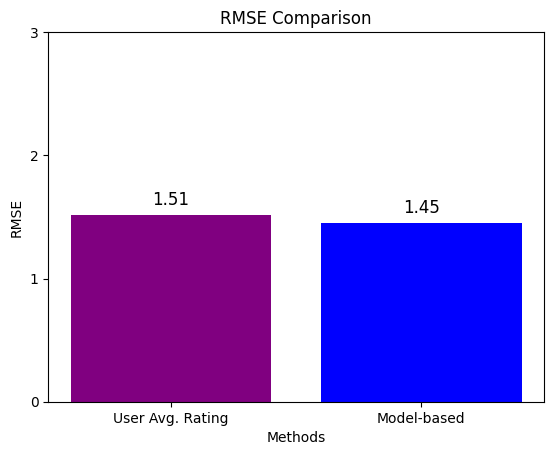

In [67]:
# RMSE 차이 시각화

# RMSE values
rmse_values = [avg_RMSE, model_RMSE]

# Labels for each method
methods = ["User Avg. Rating", "Model-based"]

# Create a bar plot
plt.bar(methods, rmse_values, color=['purple', 'blue'])
plt.xlabel("Methods")
plt.ylabel("RMSE")
plt.title("RMSE Comparison")

# Set the y-axis scale to specific intervals
plt.yticks([0, 1, 2, 3])

# Display the RMSE values on top of the bars
for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.05, str(round(v, 2)), ha='center', va='bottom', fontsize=12, color='black')

# Show the plot
plt.show()

In [68]:
# User-ID = 254.0 , Book-ID = 52 인 경우의 score 출력해보기
score = user_book_score(254.0, 52)
print('score (User {}, Book {}) is '.format(254.0, 52) , score)

score (User 254.0, Book 52) is  8.486239324172299


In [ ]:
Rating_avg = Rating_avg.astype({'Book-ID': str})
Book_user = Rating_avg.groupby(by = 'User-ID')['Book-ID'].apply(lambda x:','.join(x))

In [ ]:
def User_based_book_recom(user):
    Book_seen_by_user = ratings_matrix.columns[ratings_matrix[ratings_matrix.index == user].notna().any()].tolist()
    a = sim_user_15_u[sim_user_15_u.index == user].values
    b = a.squeeze().tolist()
    d = Book_user[Book_user.index.isin(b)]
    I = ','.join(d.values)
    Book_seen_by_similar_users =  I.split(',')
    Book_under_consideration = list(set(Book_seen_by_similar_users)-set(list(map(str, Book_seen_by_user))))
    Book_under_consideration = list(map(int, Book_under_consideration))
    score = []
    for book in Book_under_consideration:
        c = final_book.loc[:,book]
        d = c[c.index.isin(b)]
        f = d[d.notnull()]
        avg_user = Mean.loc[Mean['User-ID'] == user, 'Book-Rating'].values[0]
        index = f.index.values.squeeze().tolist()
        corr = similarity_between_users.loc[user, index]
        fin = pd.concat([f,corr], axis=1)
        fin.columns = ['adg_score', 'correlation']
        fin['score'] = fin.apply(lambda x:x['adg_score'] * x['correlation'], axis=1)
        nume = fin['score'].sum()
        deno = fin['correlation'].sum()
        final_score = avg_user + (nume/deno)
        score.append(final_score)
    data = pd.DataFrame({'Book-ID': Book_under_consideration, 'score': score})
    top_5_recommendation = data.sort_values(by='score', ascending=False).head(5)
    Book_Name_with_Score = top_5_recommendation.merge(book_value, how='inner', on='Book-ID')
    Book_Names = Book_Name_with_Score['Book-Title'].values.tolist()
    return Book_Names, Book_Name_with_Score

In [ ]:
# 관심있는 유저가 높게 평가한 책 5개만 포함된 데이터프레임을 반환하는 함수
def users_choice(id):
    users_fav=common_books[common_books["User-ID"]==id].sort_values(["Book-Rating"],ascending=False)[0:5]
    return users_fav

Enter the User-ID to whom you want to recommend(if you don't mind press 0) : 266865.0
🟦 USER: 266865.0 
 
[User's Favorite Books] :
Fast Food Nation: The Dark Side of the All-American Meal
Cold Mountain : A Novel
Brave New World
The Catcher in the Rye
White Oleander : A Novel (Oprah's Book Club)
 
[Recommended Books] : 
The Two Towers (The Lord of the Rings, Part 2)
I Know This Much Is True
Seabiscuit: An American Legend
The Red Tent (Bestselling Backlist)
Four To Score (A Stephanie Plum Novel)


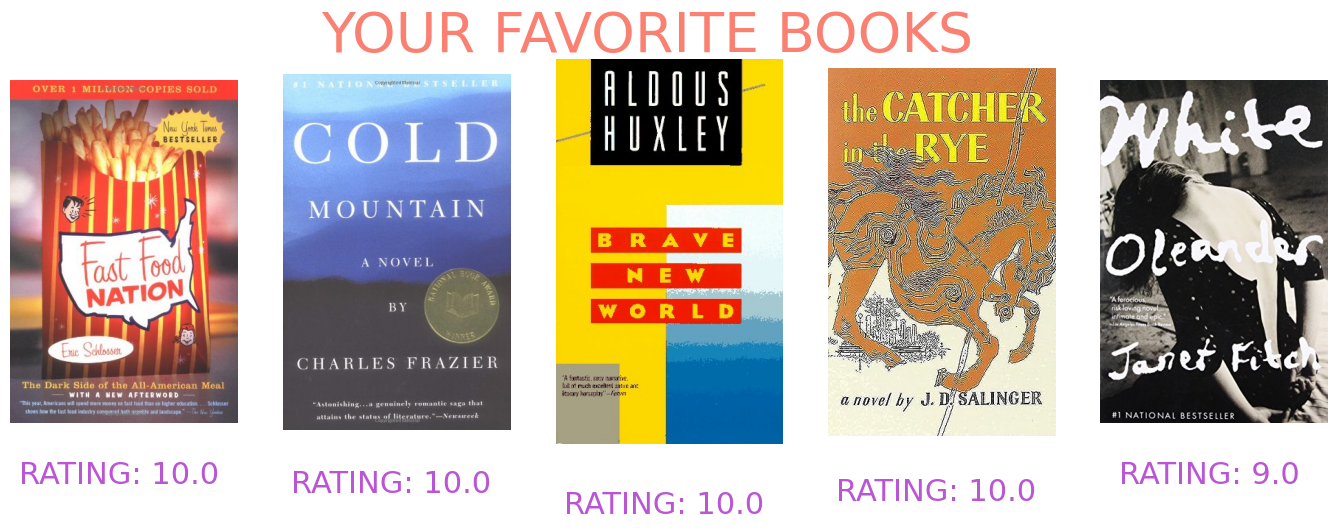

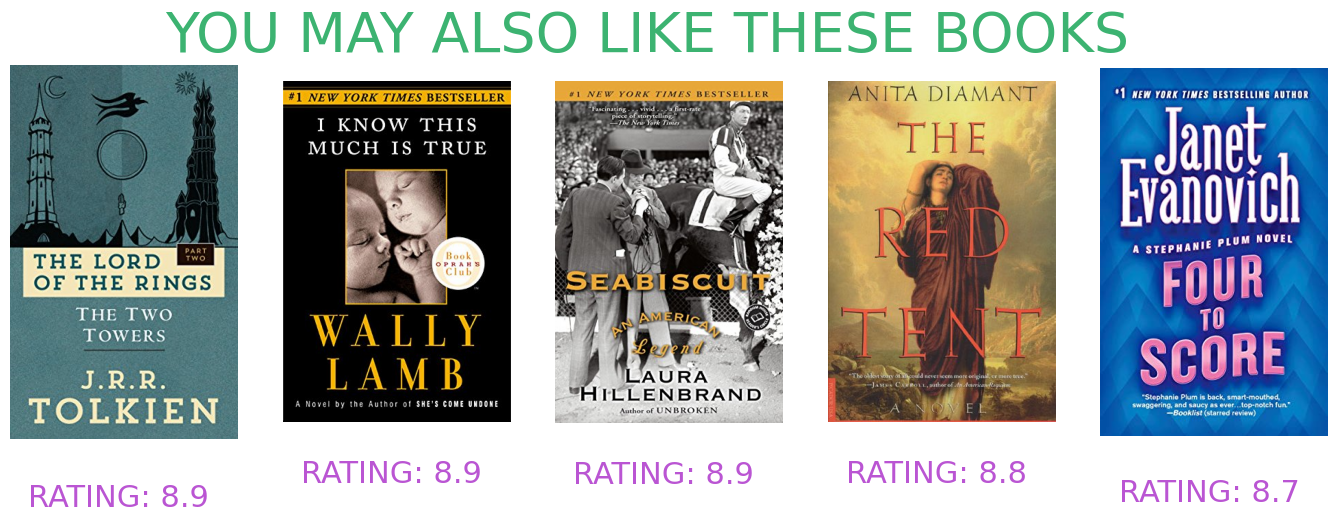

In [ ]:
# 관심 있는 유저의 id 받기
while(True):
    user = float(input("Enter the User-ID to whom you want to recommend(if you don't mind press 0) : "))
    if user == 0:
        user=random.choice(common_books["User-ID"].values)
        break
    elif common_books["User-ID"].isin([user]).any():
        break
    else:
        print("invalid user-id")

# 유저가 좋아한 책과 별점 시각화
user_favorite_df = users_choice(user)
n = len(user_favorite_df["Book-Title"].values)
print("🟦 USER: {} ".format(user))
print(" ")
print("[User's Favorite Books] :")
for i in range(n):
  print(user_favorite_df["Book-Title"].values.tolist()[i])

fig,ax=plt.subplots(1,n,figsize=(17,5))
fig.suptitle("YOUR FAVORITE BOOKS",fontsize=40,color="salmon")

for i in range(n):
    url=common_books.loc[common_books["Book-Title"]==user_favorite_df["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
    response = requests.get(url, stream=True, headers=headers)
    if response.status_code == 200:
        img = Image.open(io.BytesIO(response.content))
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title("RATING: {} ".format(user_favorite_df["Book-Rating"].values[i]),y=-0.20,color="mediumorchid",fontsize=22)
        fig.show()
    else:
        print("Failed to retrieve image from URL:", url)
        print(response.status_code)

# 입력한 유저가 관심있어할만한 책 5개 출력
predicted_books, books_with_score = User_based_book_recom(user)
print(" ")
print("[Recommended Books] : ")
for i in predicted_books:
    print(i)

# 시각화
fig,ax=plt.subplots(1,5,figsize=(17,5))
fig.suptitle("YOU MAY ALSO LIKE THESE BOOKS",fontsize=40,color="mediumseagreen")

for i in range(len(predicted_books)):
    url=common_books.loc[common_books["Book-Title"]==books_with_score["Book-Title"].tolist()[i],"Image-URL-L"][:1].values[0]
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'}
    response = requests.get(url, stream=True, headers=headers)
    if response.status_code == 200:
        img = Image.open(io.BytesIO(response.content))
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title("RATING: {} ".format(round(books_with_score["score"].values[i], 1)),y=-0.20,color="mediumorchid",fontsize=22)
        fig.show()
    else:
        print("Failed to retrieve image from URL:", url)
        print(response.status_code)

# User-based Ver.2

### 두 번째 User-based collaborative filtering은 Pearson correlation coefficient를 사용한 방법이다.

In [ ]:
#user_book dataset을 만들자!
user_book_df = common_books.pivot_table(index=['User-ID'],
                                        columns=['Book-Title'],
                                        values='Book-Rating')

In [ ]:
#랜덤으로 유저를 선택하자
random_user = 136382

In [ ]:
random_user_df = user_book_df[user_book_df.index == random_user]
random_user_df

Book-Title,1984,1st to Die: A Novel,2nd Chance,A Bend in the Road,"A Child Called \It\"": One Child's Courage to Survive""",A Heartbreaking Work of Staggering Genius,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),A Map of the World,A Painted House,A Prayer for Owen Meany,...,Watership Down,We Were the Mulvaneys,When the Wind Blows,Where the Heart Is (Oprah's Book Club (Paperback)),While I Was Gone,White Oleander : A Novel,White Oleander : A Novel (Oprah's Book Club),Wicked: The Life and Times of the Wicked Witch of the West,Wild Animus,"\O\"" Is for Outlaw"""
User-ID,,,,,,,,,,,,,,,,,,,,,
136382.0,NaN,8.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# our aim is to find the books that random user has rated
books_read = random_user_df.columns[random_user_df.notna().any()].tolist()
books_read

['1st to Die: A Novel',
 'A Is for Alibi (Kinsey Millhone Mysteries (Paperback))',
 'Back Roads',
 'Dreamcatcher',
 'Four To Score (A Stephanie Plum Novel)',
 'Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel)',
 'Midwives: A Novel',
 'Seven Up (A Stephanie Plum Novel)',
 'Skipping Christmas',
 'The Fellowship of the Ring (The Lord of the Rings, Part 1)',
 'The Poisonwood Bible: A Novel',
 'The Rainmaker',
 'The Rescue',
 'The Runaway Jury',
 'The Street Lawyer']

In [ ]:
len(books_read)

15

In [ ]:
# with random user, those who rate the same books are listed

books_read_df = user_book_df[books_read]
books_read_df

Book-Title,1st to Die: A Novel,A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),Back Roads,Dreamcatcher,Four To Score (A Stephanie Plum Novel),Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel),Midwives: A Novel,Seven Up (A Stephanie Plum Novel),Skipping Christmas,"The Fellowship of the Ring (The Lord of the Rings, Part 1)",The Poisonwood Bible: A Novel,The Rainmaker,The Rescue,The Runaway Jury,The Street Lawyer
User-ID,,,,,,,,,,,,,,,
254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN
638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,9.0,NaN,NaN
2766.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
4017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6242.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274301.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
276050.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# determine how many books each user rating

user_book_count = books_read_df.T.notnull().sum()
user_book_count

User-ID
254.0       1
638.0       2
2766.0      2
4017.0      0
6242.0      0
           ..
274004.0    0
274301.0    1
276050.0    2
276165.0    0
276231.0    0
Length: 434, dtype: int64

In [ ]:
#  organizing the data set

user_book_count = user_book_count.reset_index()
user_book_count.columns = ["User_id", "book_count"]
user_book_count.sort_values("book_count", ascending=False)

,User_id,book_count
209,136382.0,15
19,11676.0,13
25,16795.0,10
161,104636.0,8
399,258534.0,6
...,...,...
310,207782.0,0
121,85426.0,0
312,208671.0,0
118,81318.0,0


In [ ]:
# at least 5 people commenting on the same books with random user

users_same_book = user_book_count[user_book_count["book_count"] > 5]["User_id"]
users_same_book

19      11676.0
25      16795.0
161    104636.0
209    136382.0
399    258534.0
Name: User_id, dtype: float64

In [ ]:
# Determining the Users with the Most Similar Behavior with the User to Make a Recommendation
# merged data of other users with the random user

final_df = pd.concat([books_read_df[books_read_df.index.isin(users_same_book)],
                      random_user_df[books_read]])

In [ ]:
# correlations for all users .
# organizing the data set

corr_df = final_df.T.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['user_id_1', 'user_id_2']
corr_df = corr_df.reset_index()
top_users = corr_df[(corr_df["user_id_1"] == random_user)][["user_id_2", "corr"]].reset_index(drop=True)

top_users

,user_id_2,corr
0,258534.0,-0.241191
1,16795.0,0.750373
2,136382.0,1.000000


In [ ]:
# other users with 60% positive correlation with random user

top_users = corr_df[(corr_df["user_id_1"] == random_user) & (corr_df["corr"] >  0.60)][
    ["user_id_2", "corr"]].reset_index(drop=True)

top_users = top_users.sort_values(by='corr', ascending=False)
top_users.rename(columns={"user_id_2": "User-ID"}, inplace=True)
top_users

,User-ID,corr
1,136382.0,1.000000
0,16795.0,0.750373


In [ ]:
top_users_ratings = top_users.merge(ratings[["User-ID", "ISBN", "Book-Rating"]], how='inner')
top_users_ratings = top_users_ratings[top_users_ratings["User-ID"] != random_user]

top_users_ratings

,User-ID,corr,ISBN,Book-Rating
437,16795.0,0.750373,0006093090X,8
438,16795.0,0.750373,000670891576,8
439,16795.0,0.750373,0020280505,8
440,16795.0,0.750373,0020419805,8
441,16795.0,0.750373,002517990X,6
...,...,...,...,...
3380,16795.0,0.750373,1890627062,0
3381,16795.0,0.750373,1930408048,0
3382,16795.0,0.750373,1930722028,0
3383,16795.0,0.750373,9994438859,0


In [ ]:
# with correlation we combine the effect of the rating
top_users_ratings['weighted_rating'] = top_users_ratings['corr'] * top_users_ratings['Book-Rating']

top_users_ratings

,User-ID,corr,ISBN,Book-Rating,weighted_rating
437,16795.0,0.750373,0006093090X,8,6.002985
438,16795.0,0.750373,000670891576,8,6.002985
439,16795.0,0.750373,0020280505,8,6.002985
440,16795.0,0.750373,0020419805,8,6.002985
441,16795.0,0.750373,002517990X,6,4.502239
...,...,...,...,...,...
3380,16795.0,0.750373,1890627062,0,0.000000
3381,16795.0,0.750373,1930408048,0,0.000000
3382,16795.0,0.750373,1930722028,0,0.000000
3383,16795.0,0.750373,9994438859,0,0.000000


In [ ]:
recommendation_df = top_users_ratings.groupby('ISBN').agg({"weighted_rating": "mean"})
recommendation_df = recommendation_df.reset_index()
recommendation_df

,ISBN,weighted_rating
0,0006093090X,6.002985
1,000670891576,6.002985
2,0020280505,6.002985
3,0020419805,6.002985
4,002517990X,4.502239
...,...,...
2943,1890627062,0.000000
2944,1930408048,0.000000
2945,1930722028,0.000000
2946,9994438859,0.000000


In [ ]:
# We list the top 10 with a weighted_rating greater than 6.5
books_to_be_recommend = recommendation_df[recommendation_df["weighted_rating"] > 6.5].sort_values("weighted_rating", ascending=False).head(10)

books_to_be_recommend

,ISBN,weighted_rating
1624,0515120898,7.503732
1669,0525945210,7.503732
558,0345423097,7.503732
2653,0866852611,7.503732
1623,051511992X,7.503732
811,0375412824,7.503732
1607,0515102636,7.503732
2521,0811801802,7.503732
2506,0805061762,7.503732
2195,0684842327,7.503732


In [ ]:
# we merge with df to see the name of the books
# random_user = 136382

books_to_be_recommend.merge(books_data[["ISBN", "Book-Title"]]).drop_duplicates()

,ISBN,weighted_rating,Book-Title
0,0515120898,7.503732,The Pull of the Moon
69,0525945210,7.503732,A Man Named Dave: A Story of Triumph and Forgi...
103,0345423097,7.503732,Joy School (Ballantine Reader's Circle)
151,0866852611,7.503732,Love Story (Arabic)
152,051511992X,7.503732,That Camden Summer
253,0375412824,7.503732,The Dive From Clausen's Pier (Alex Awards)
373,0515102636,7.503732,Morning Glory
433,0811801802,7.503732,Sabine's Notebook: In Which the Extraordinary ...
486,0805061762,7.503732,"A Gentle Madness : Bibliophiles, Bibliomanes, ..."
499,0684842327,7.503732,NEEDLES : A MEMOIR OF GROWING UP WITH DIABETES


# Item-based Collaborative Filtering

In [ ]:
df=books_data.copy()
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(columns=["ISBN","Year-Of-Publication","Image-URL-S","Image-URL-M"],axis=1,inplace=True)
df.drop(index=df[df["Book-Rating"]==0].index,inplace=True)
df["Book-Title"]=df["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
df.head()

,Book-Title,Book-Author,Publisher,Image-URL-L,User-ID,Book-Rating
1,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0
3,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,11676.0,8.0
5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,67544.0,8.0
8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,116866.0,9.0
9,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,123629.0,9.0


In [ ]:
def item_based(bookTitle):
    bookTitle = str(bookTitle)

    if bookTitle in df["Book-Title"].values:
        rating_count = pd.DataFrame(df["Book-Title"].value_counts())
        rare_books = rating_count[rating_count["Book-Title"] <= 200].index
        common_books = df[~df["Book-Title"].isin(rare_books)]

        if bookTitle in rare_books:
            # 가장 인기 있는 책 5권을 추천합니다.
            most_popular = df["Book-Title"].value_counts().index[:5]
            print("이 책에 대한 추천이 없습니다.\n")
            print("가장 인기 있는 책 5권을 시도해 볼 수 있습니다: \n")
            for i, title in enumerate(most_popular, start=1):
                print("{}. {}".format(i, title))
        else:
            common_books_pivot = common_books.pivot_table(index=["User-ID"], columns=["Book-Title"], values="Book-Rating")
            title = common_books_pivot[bookTitle]

            # 코사인 유사도 계산
            similarities = cosine_similarity(common_books_pivot.T.fillna(0))
            similar_scores = pd.Series(similarities[title.index.get_loc(bookTitle)])

            recommendation_df = pd.DataFrame({'Book-Title': title.index, 'Cosine-Similarity': similar_scores})
            recommendation_df = recommendation_df.sort_values(by='Cosine-Similarity', ascending=False)

            # 현재 책을 추천에서 제외합니다.
            recommendation_df = recommendation_df[recommendation_df['Book-Title'] != bookTitle]

            less_rating = []
            for i in recommendation_df["Book-Title"]:
                if df[df["Book-Title"] == i]["Book-Rating"].mean() < 5:
                    less_rating.append(i)
            if recommendation_df.shape[0] - len(less_rating) > 5:
                recommendation_df = recommendation_df[~recommendation_df["Book-Title"].isin(less_rating)]

            recommendation_df = recommendation_df.head


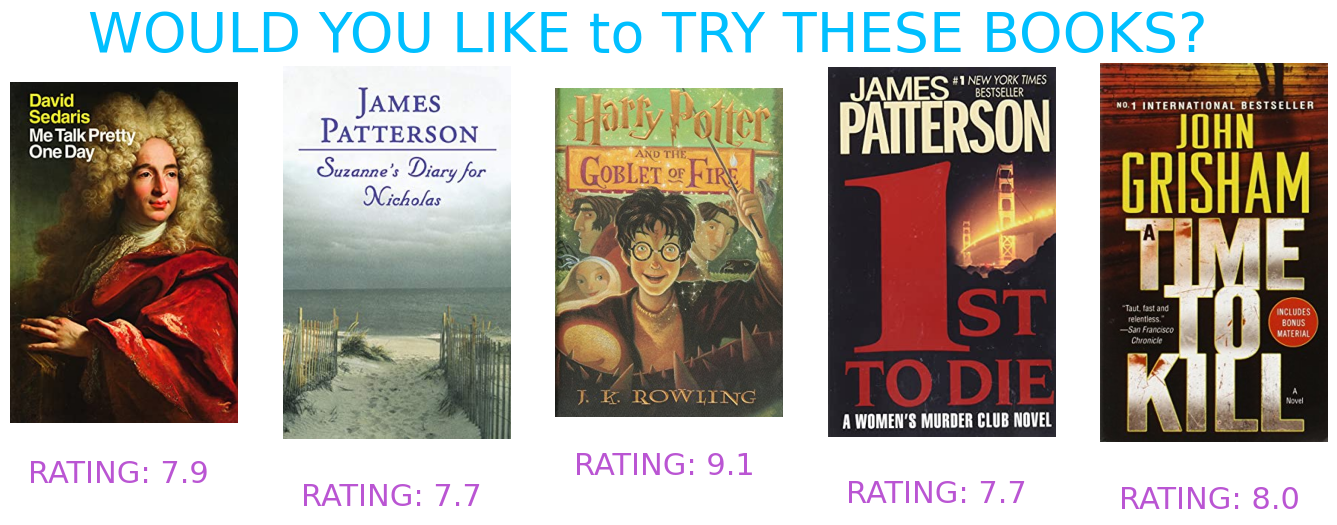

In [ ]:
#선택한 책들과 유사한 책들 추천
item_based("The Chamber")